# Lab 3

### Simon Jasansky

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#import data
df = pd.read_csv("data/caravan.csv")

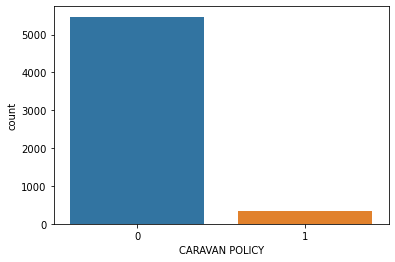

Positive instances: 348
Negative instances: 5474


,count,mean,std,min,25%,50%,75%,max
Customer Subtype,5822.0,24.253349,12.846706,1.0,10.0,30.0,35.0,41.0
Number of houses,5822.0,1.110615,0.405842,1.0,1.0,1.0,1.0,10.0
Avg size household,5822.0,2.678805,0.789835,1.0,2.0,3.0,3.0,5.0
Avg Age,5822.0,2.991240,0.814589,1.0,2.0,3.0,3.0,6.0
Customer main type,5822.0,5.773617,2.856760,1.0,3.0,7.0,8.0,10.0
...,...,...,...,...,...,...,...,...
Number of boat policies,5822.0,0.006012,0.081632,0.0,0.0,0.0,0.0,2.0
Number of bicycle policies,5822.0,0.031776,0.210986,0.0,0.0,0.0,0.0,3.0
Number of property insurance policies,5822.0,0.007901,0.090463,0.0,0.0,0.0,0.0,2.0
Number of social security insurance policies,5822.0,0.014256,0.119996,0.0,0.0,0.0,0.0,2.0


In [55]:
# data exploration
sns.countplot(x = df["CARAVAN POLICY"])
plt.show()

print("Positive instances: " + str(df["CARAVAN POLICY"].sum()) + "")
print("Negative instances: " + str(len(df.loc[df["CARAVAN POLICY"] == 0])))

df.describe().T

Not very balanced dataset

## Assignment 1
### Describe the actual or potential customers and possibly explain why these customers buy a caravan policy.

1.1:
The purpose of assignment 1 is to give a clear insight to why customers have a caravan insurance
policy and how these customers are different from other customers. Descriptions can be based on
regression equations, decision trees, linguistic descriptions, graphical representations or any other
form. The descriptions and accompanying interpretation must be comprehensible, useful and
actionable for a marketing professional with no prior knowledge of data mining.

1.2:
Compare some different techniques and/or settings of parameters to see how well they perform
on this problem. For this comparison you may assume some basic knowledge about data mining
with the reader. In Appendix B details are provided how to use scikit-learn For feature selectio

In [56]:
# Approaches:
# logistic regression with lasso regularization (good explainability)
# decision trees or decision rules, output the paths that lead to buying caravan insurance
# KNN
# linguistic descriptions: interpret the models
# graphical representations: Bar-chart with positive and negative contribution derived from logistic regression

In [57]:
# Train Test Split
from sklearn.model_selection import train_test_split

X = df.drop('CARAVAN POLICY', axis=1)
y = df["CARAVAN POLICY"]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.3,
                                                      random_state=12341234)

In [86]:
# check if there are features which have the same number for more than 100% of the cases, i.e zero variance
print(df.columns[df.nunique() == 1])
X_train.columns[X_train.nunique() == 1]


Index([], dtype='object')


Index(['Contribution surfboard policies', 'Number of surfboard policies'], dtype='object')

In [92]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
print(X.shape)

X_new = SelectKBest(chi2, k=20).fit(X)
print(X_new)
X_new.transform(y)
X_new.shape
X_new

(5822, 85)


TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import copy

In [33]:
%%capture
# Implement logistic regression with lasso regularization
X_names = [x for x in df.columns if x != "CARAVAN POLICY"]
X = np.array(df[X_names])
Y = np.array(df["CARAVAN POLICY"])

Y_pred = cross_val_predict(LogisticRegression(max_iter = 1000,
                                              penalty='l1',
                                              solver='liblinear'),
                           X, Y, cv = 10)
conf_mat = confusion_matrix(Y, Y_pred)
accuracy = accuracy_score(Y, Y_pred)

In [34]:
print(Y)
print(conf_mat)
print(accuracy)

[0 0 0 ... 1 0 0]
[[5462   12]
 [ 346    2]]
0.9385091034008932


In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE

classifier = LogisticRegression()
pipeClassifier = make_pipeline(SelectKBest(chi2, k=8), classifier)
#k is the number of variables selected
pipeClassifier.fit(X, Y)

pipeClassifier.score(X, Y)

0.9398832016489179

## Assignment 2
### Select customers from a test file to send information to. The file with those customers will be provided on the day of lab’s deadline.

The purpose of assignment 2 is to find a set of 800 customers from the test set that contains the
most caravan policy owners. Use your most accurate model to select the 800 most likely policy
owners.